In [43]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [45]:
df = pd.read_csv('df_preprocessed.csv')
df.head()
x = df.drop(['DEP_DELAY'], axis=1)
y = df['DEP_DELAY']

If delay is more than 15 minutes, it is considered as delayed
1 ->delayed
0 ->not delayed

In [46]:
print(df['DEP_DELAY'].value_counts())

0    24946
1     3874
Name: DEP_DELAY, dtype: int64


In [47]:
24946/(3874+24946)

0.8655794587092297

PCA

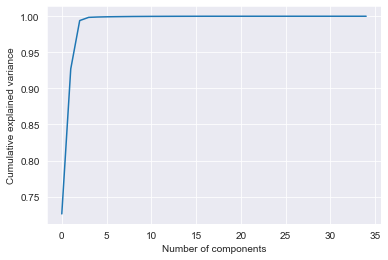

In [48]:
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [49]:
print(x.shape)
print(type(x))

(28820, 35)
<class 'pandas.core.frame.DataFrame'>


Taking 4 components

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
torch.Size([5764, 4]) torch.Size([5764, 1]) torch.Size([23056, 4]) torch.Size([23056, 1])
Epoch [1/50], Loss: 0.8162
Epoch [2/50], Loss: 0.7990
Epoch [3/50], Loss: 0.7825
Epoch [4/50], Loss: 0.7669
Epoch [5/50], Loss: 0.7520
Epoch [6/50], Loss: 0.7379
Epoch [7/50], Loss: 0.7244
Epoch [8/50], Loss: 0.7117
Epoch [9/50], Loss: 0.6996
Epoch [10/50], Loss: 0.6881
Epoch [11/50], Loss: 0.6771
Epoch [12/50], Loss: 0.6666
Epoch [13/50], Loss: 0.6565
Epoch [14/50], Loss: 0.6468
Epoch [15/50], Loss: 0.6376
Epoch [16/50], Loss: 0.6288
Epoch [17/50], Loss: 0.6203
Epoch [18/50], Loss: 0.6122
Epoch [19/50], Loss: 0.6044
Epoch [20/50], Loss: 0.5969
Epoch [21/50], Loss: 0.5897
Epoch [22/50], Loss: 0.5828
Epoch [23/50], Loss: 0.5762
Epoch [24/50], Loss: 0.5698
Epoch [25/50], Loss: 0.5638
Epoch [26/50], Loss: 0.5579
Epoch [27/50], Loss: 0.5523
Epoch [28/50], Loss: 0.5469
Epoch [29/50], 

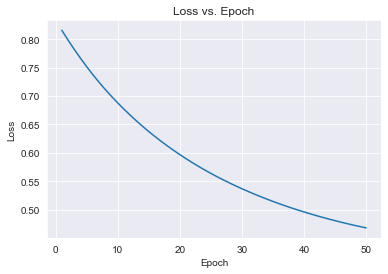

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


pca = PCA(n_components=4)
x = pca.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# change to numpy
print(type(X_train), type(y_train), type(X_test), type(y_test))
# chnage to tensor
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

y_train = torch.from_numpy(y_train).float().view(-1, 1)

print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

# Define the neural network model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 4)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification
    #     initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation for binary classification
        return x

# Initialize the model
model = LogisticRegressionModel(input_size=4)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=1e-5)  # Stochastic Gradient Descent

# Prepare data using DataLoader
batch_size = 16
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x)

        # Compute the binary cross-entropy loss
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the average loss for this epoch to the list
    losses.append(epoch_loss / len(dataloader))

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {losses[-1]:.4f}')

# Print the final learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')

# Optionally, plot the loss versus epoch
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid(True)
plt.show()


In [57]:
# save this model criterion and optimizer
# torch.save({
#             'epoch': num_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': criterion,
#             }, "model.pt")

torch.save(model.state_dict(), 'model2.pt')
# save the optimizer
torch.save(optimizer.state_dict(), 'optimizer2.pt')
# save the criterion
torch.save(criterion.state_dict(), 'criterion2.pt')


In [54]:
# test the model
y_pred = model(X_test)
#calculate bcross entropy loss
loss = criterion(y_pred, y_test)
print(f'Loss: {loss.item():.4f}')
#accuracy of the model
y_pred = torch.round(y_pred)
correct = (y_pred == y_test).sum().item()
accuracy = correct / len(y_test)
print(f'Accuracy: {accuracy:.4f}')

Loss: 0.4737
Accuracy: 0.8685


In [56]:
#find recall and precision
from sklearn.metrics import precision_score, recall_score
y_pred = y_pred.detach().numpy()
y_test = y_test.detach().numpy()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
# find f1 score and confusion matrix
from sklearn.metrics import f1_score, confusion_matrix
f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.4f}')
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{cm}')



Precision: 1.0000, Recall: 0.0417
F1 score: 0.0801
Confusion matrix:
[[4973    0]
 [ 758   33]]
